In [1]:
import pathlib

import cdflib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.constants
import torch
from cdasws import CdasWs

from pymfr.detect import detect_flux_ropes

In [2]:
time = ['2016-01-01T00:00:00Z', '2016-01-02T00:00:00Z']

file_name = f"./data/wind_{time[0]}_{time[1]}_1min_nonlin.npz"
if not pathlib.Path(file_name).exists():
    cdas = CdasWs()

    status, data = cdas.get_data('WI_H1_SWE', ['Proton_VX_nonlin',
                                               'Proton_VY_nonlin',
                                               'Proton_VZ_nonlin',
                                               'Proton_Np_nonlin',
                                               'Proton_W_nonlin'],
                                 time[0], time[1])

    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)

    velocity = np.column_stack([data.Proton_VX_nonlin.values,
                                data.Proton_VY_nonlin.values,
                                data.Proton_VZ_nonlin.values])
    velocity[np.any(velocity == data.Proton_VX_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VY_nonlin.FILLVAL, axis=1)] = np.nan
    velocity[np.any(velocity == data.Proton_VZ_nonlin.FILLVAL, axis=1)] = np.nan
    velocity = pd.DataFrame(velocity, index=pd.DatetimeIndex(datetime)).interpolate()
    velocity = velocity.resample("60s").mean().shift(0.5, freq="60s").interpolate()
    times = velocity.index.values

    density = data.Proton_Np_nonlin.values
    density[density == data.Proton_Np_nonlin.FILLVAL] = np.nan
    density = pd.Series(density, index=pd.DatetimeIndex(datetime)).interpolate()
    density = density.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    temperature = data.Proton_W_nonlin.values
    temperature[temperature == data.Proton_W_nonlin.FILLVAL] = np.nan
    temperature = (temperature * 1e3) ** 2 * scipy.constants.m_p / (2 * scipy.constants.Boltzmann) / 1e6
    temperature = pd.Series(temperature, index=pd.DatetimeIndex(datetime)).interpolate()
    temperature = temperature.resample("60s").mean().shift(0.5, freq="60s").interpolate()

    status, data = cdas.get_data('WI_H0_MFI', ['BGSE'], time[0], time[1])

    magnetic_field = data.BGSE.values
    magnetic_field[np.any(magnetic_field == data.BGSE.FILLVAL, axis=1), :] = np.nan
    datetime = cdflib.epochs.CDFepoch().to_datetime(data.Epoch.values, to_np=True)
    magnetic_field = pd.DataFrame(magnetic_field, index=pd.DatetimeIndex(datetime)).interpolate()

    magnetic_field = magnetic_field.truncate(times[0], times[-1])
    density = density.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    temperature = temperature.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    velocity = velocity.truncate(magnetic_field.index[0], magnetic_field.index[-1]).values
    times = magnetic_field.index.values

    assert len(magnetic_field) == len(velocity) == len(density)

    np.savez_compressed(file_name, magnetic_field=magnetic_field, velocity=velocity, density=density, temperature=temperature, times=times)

data = np.load(file_name)

magnetic_field = torch.as_tensor(data["magnetic_field"], dtype=torch.float32)
velocity = torch.as_tensor(data["velocity"], dtype=torch.float32)
density = torch.as_tensor(data["density"], dtype=torch.float32)
temperature = torch.as_tensor(data["temperature"], dtype=torch.float32)
times = data["times"]

In [3]:
durations = range(10, 200)

gas_pressure = scipy.constants.Boltzmann * (density * 1e6) * (temperature * 1e6) * 1e9

results = detect_flux_ropes(magnetic_field, velocity, density, gas_pressure,
                            batch_size_mb=4096,
                            window_steps=[max(duration // 16, 1) for duration in durations],
                            window_lengths=durations, min_strength=5, frame_type="vht")

100%|██████████| 190/190 [00:02<00:00, 84.25it/s] 


2016-01-01T00:20:30.000000000  to  2016-01-01T00:29:30.000000000
duration: 10
error: 0.1 0.102
walen slope: -0.184
<B>: 14.78
Altitude/azimuth: 121 / 189
Frame quality: 0.9955619510765518


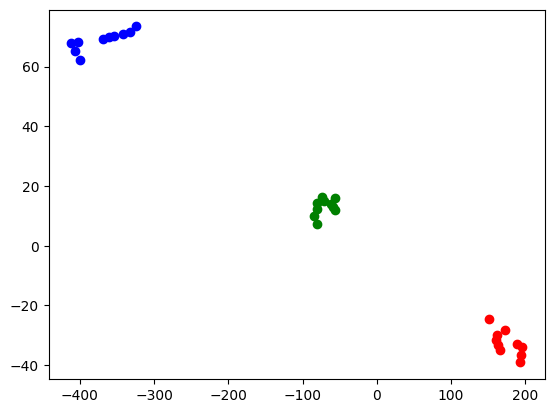

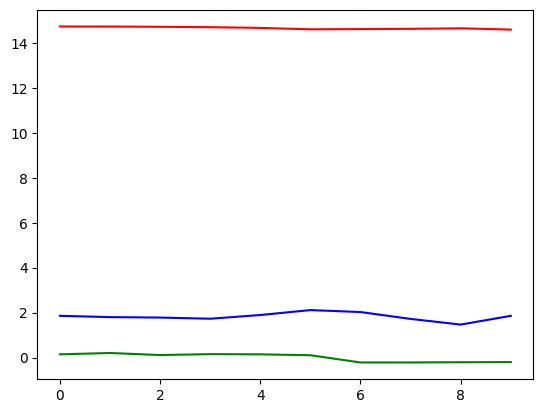

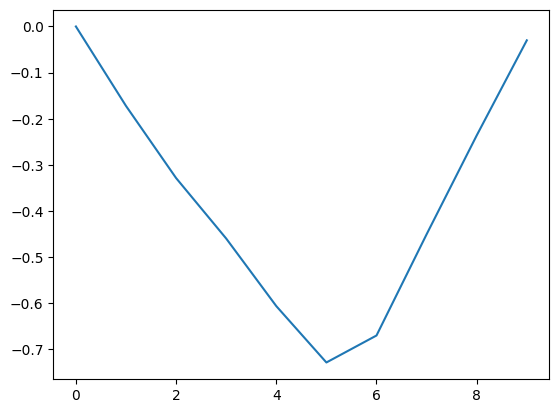

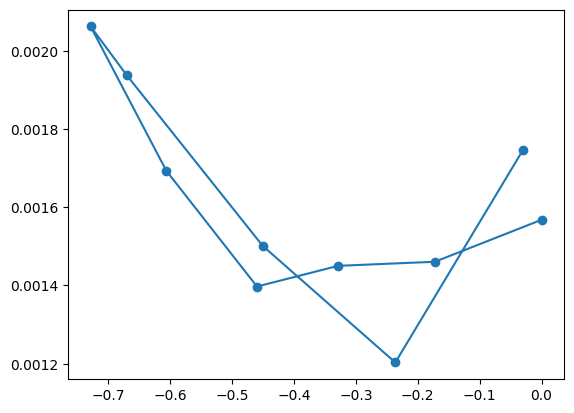

2016-01-01T02:54:30.000000000  to  2016-01-01T03:05:30.000000000
duration: 12
error: 0.119 0.104
walen slope: -0.223
<B>: 13.32
Altitude/azimuth: 102 / 187
Frame quality: 0.9944937980895903


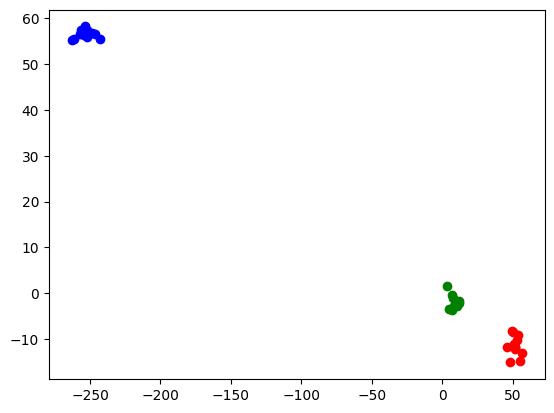

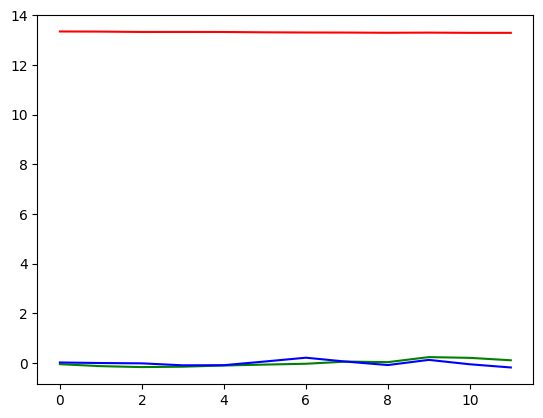

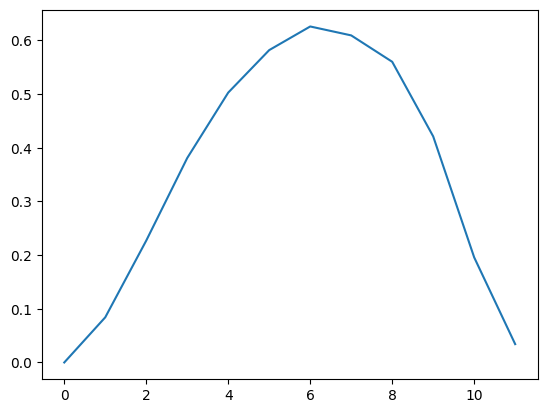

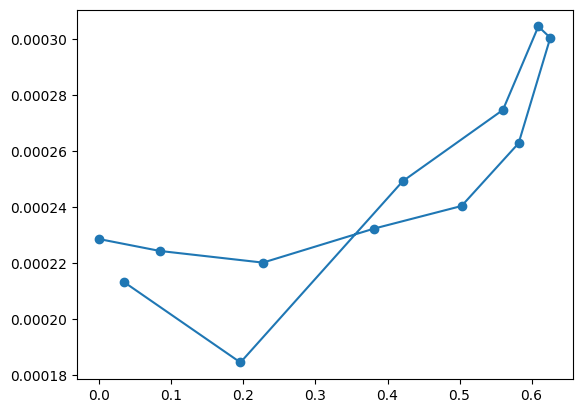

2016-01-01T03:11:30.000000000  to  2016-01-01T05:53:30.000000000
duration: 163
error: 0.12 0.108
walen slope: 0.009
<B>: 11.86
Altitude/azimuth: 122 / 199
Frame quality: 0.9966471847994639


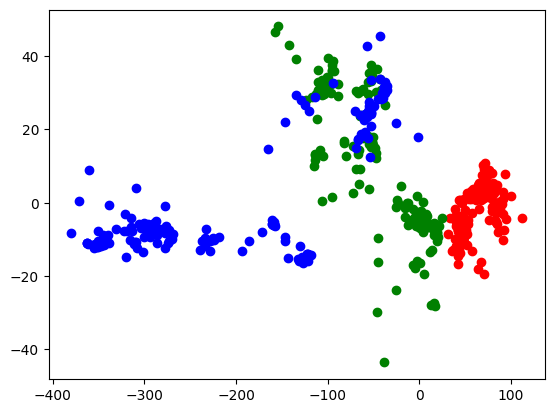

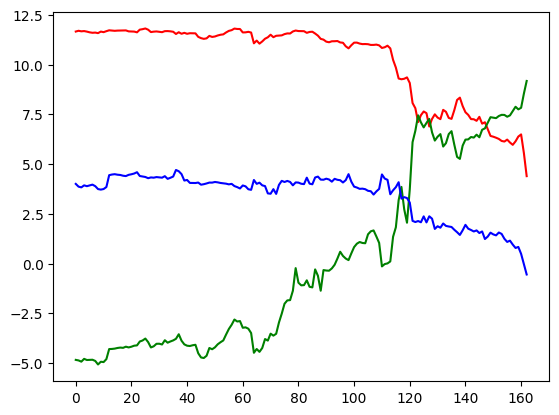

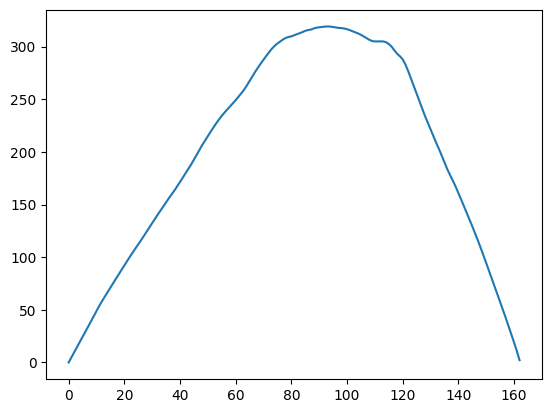

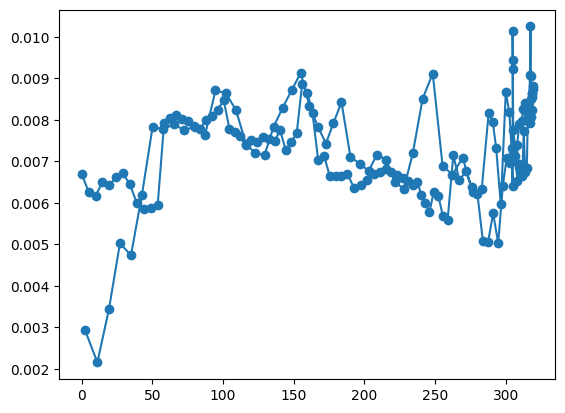

2016-01-01T05:58:30.000000000  to  2016-01-01T06:24:30.000000000
duration: 27
error: 0.089 0.116
walen slope: 0.045
<B>: 10.43
Altitude/azimuth: 114 / 336
Frame quality: 0.9928352106840114


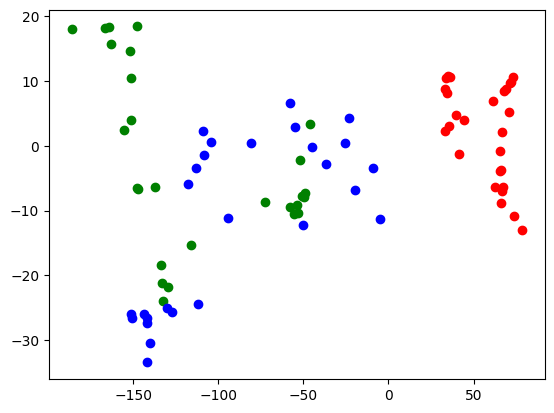

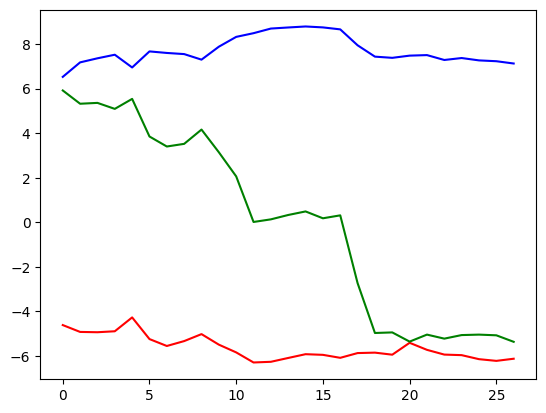

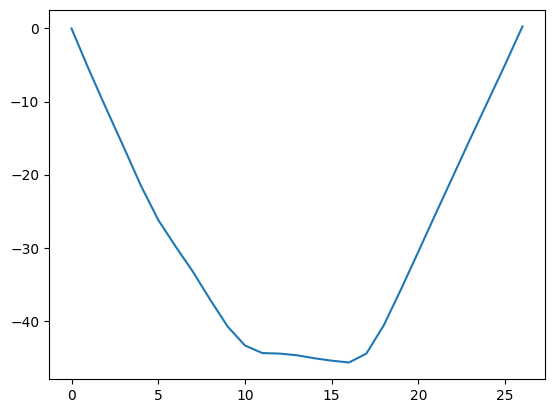

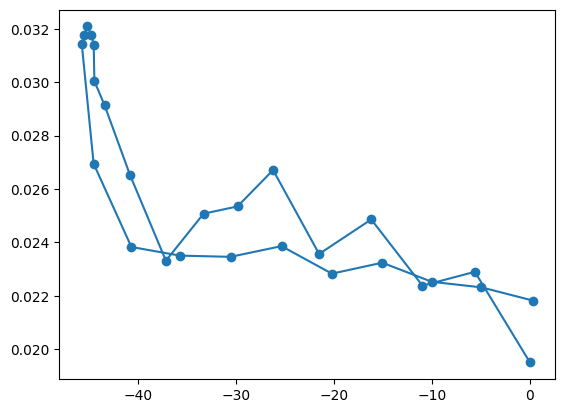

2016-01-01T06:25:30.000000000  to  2016-01-01T07:15:30.000000000
duration: 51
error: 0.113 0.112
walen slope: -0.218
<B>: 10.91
Altitude/azimuth: 147 / 297
Frame quality: 0.9959298587505768


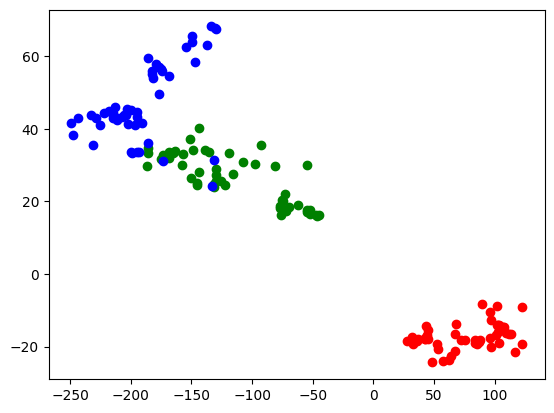

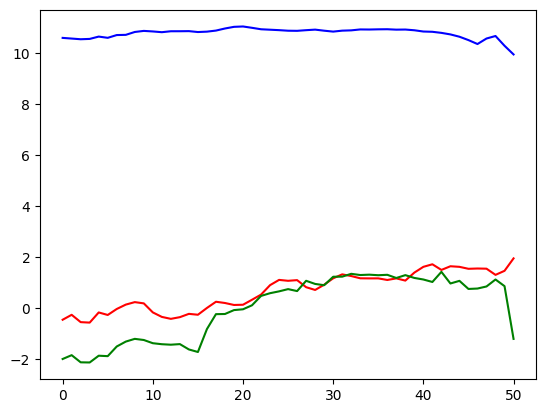

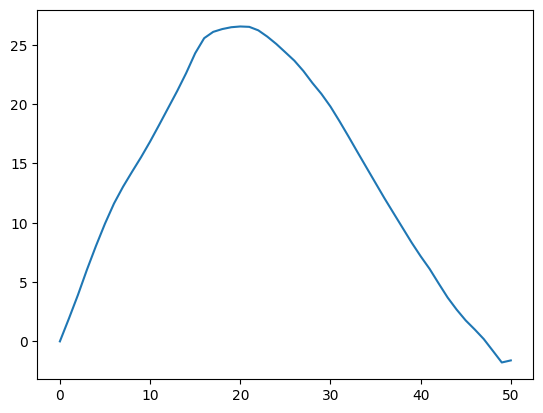

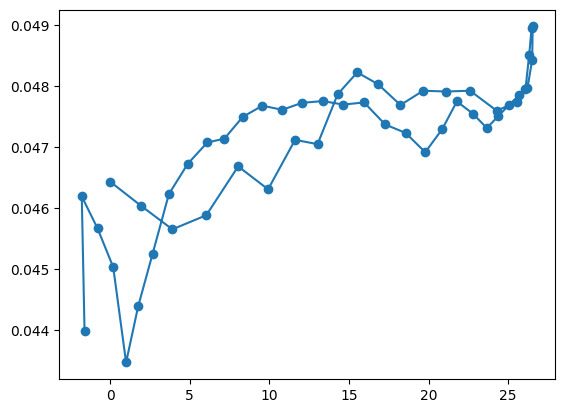

2016-01-01T07:49:30.000000000  to  2016-01-01T11:07:30.000000000
duration: 199
error: 0.113 0.134
walen slope: -0.075
<B>: 9.89
Altitude/azimuth: 86 / 343
Frame quality: 0.9963168080906212


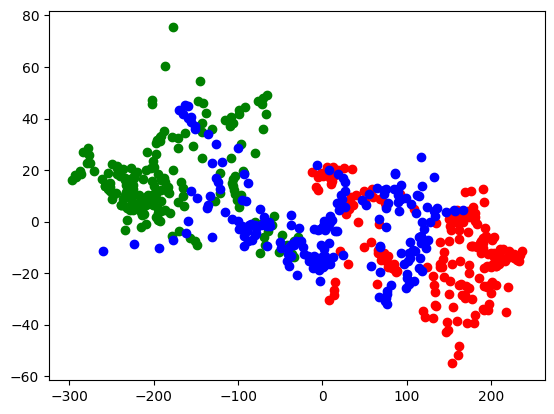

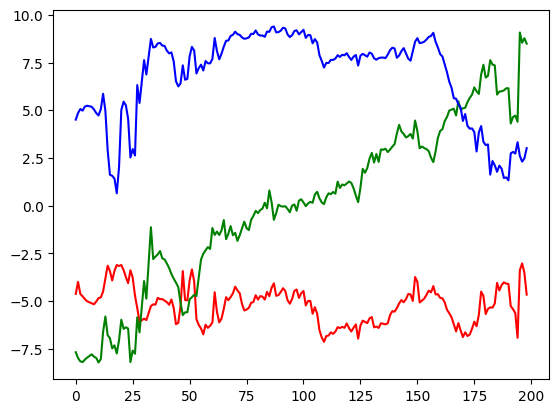

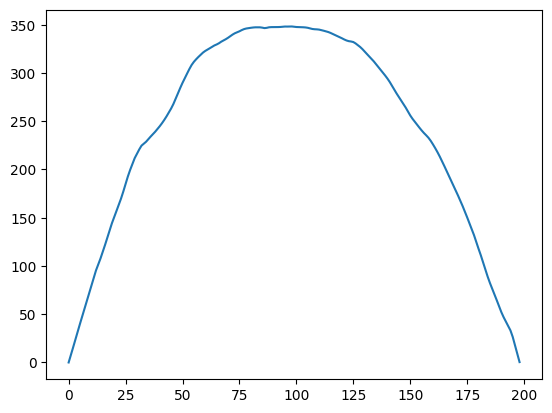

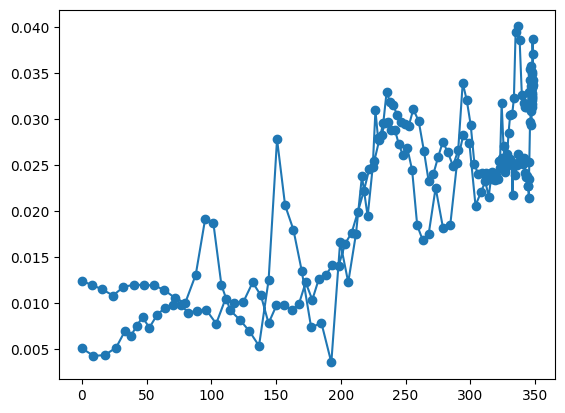

2016-01-01T11:24:30.000000000  to  2016-01-01T11:41:30.000000000
duration: 18
error: 0.097 0.124
walen slope: 0.028
<B>: 8.93
Altitude/azimuth: 36 / 279
Frame quality: 0.9933045701338286


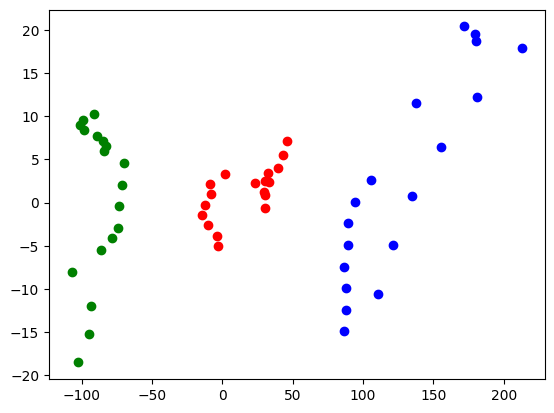

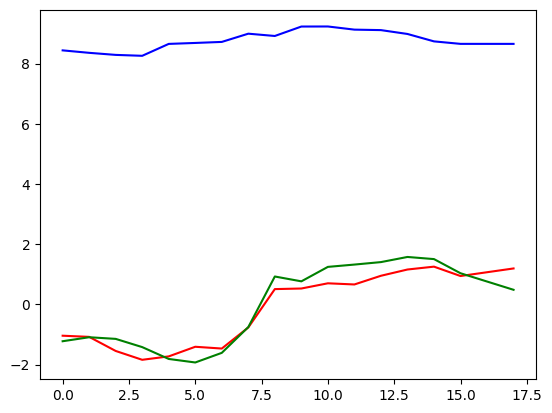

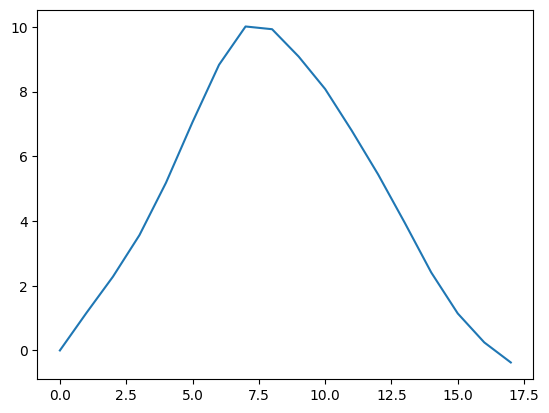

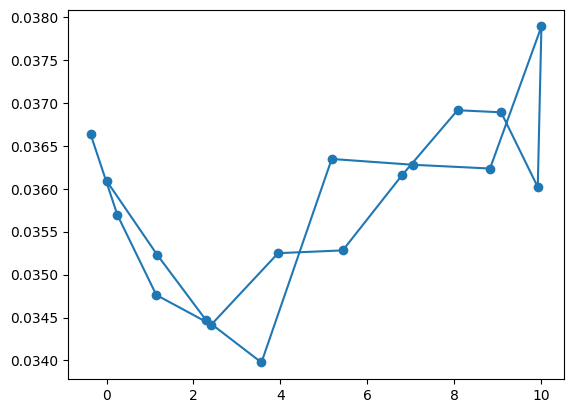

2016-01-01T11:54:30.000000000  to  2016-01-01T12:10:30.000000000
duration: 17
error: 0.119 0.095
walen slope: 0.091
<B>: 9.93
Altitude/azimuth: 108 / 221
Frame quality: 0.9918714180433407


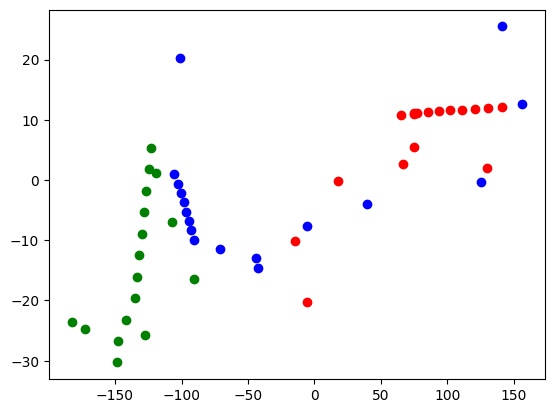

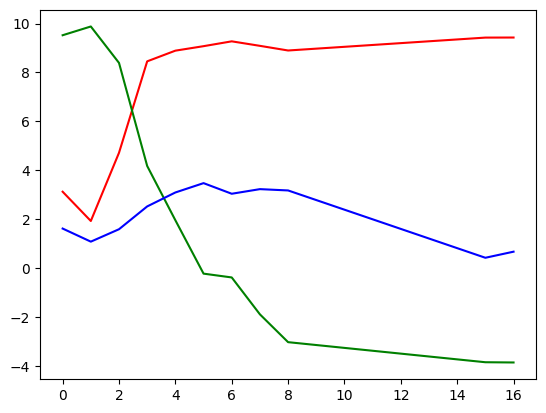

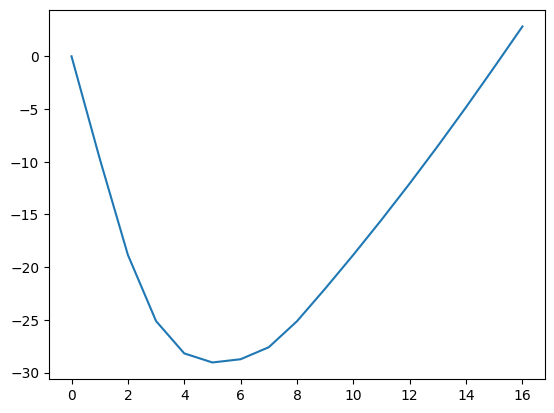

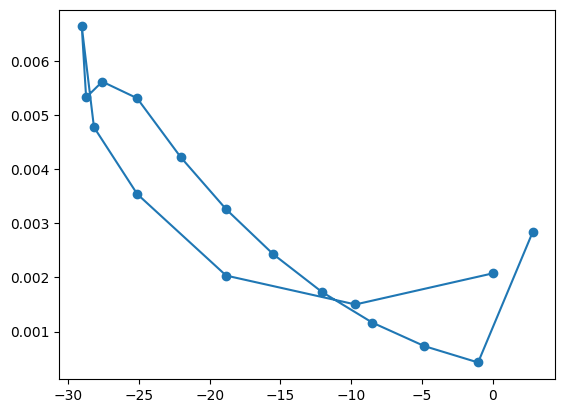

2016-01-01T12:23:30.000000000  to  2016-01-01T12:34:30.000000000
duration: 12
error: 0.079 0.113
walen slope: -0.016
<B>: 9.65
Altitude/azimuth: 80 / 29
Frame quality: 0.9955728366147606


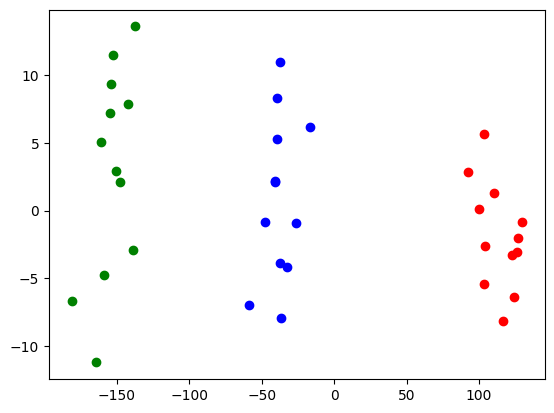

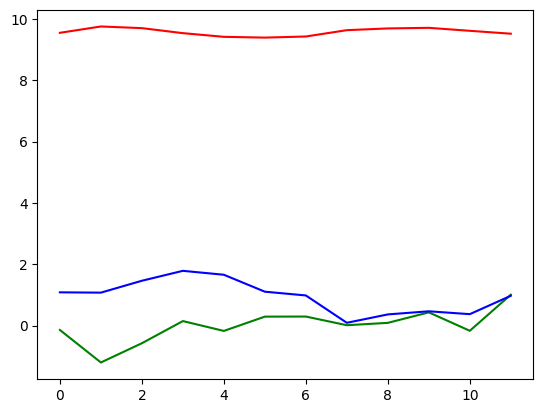

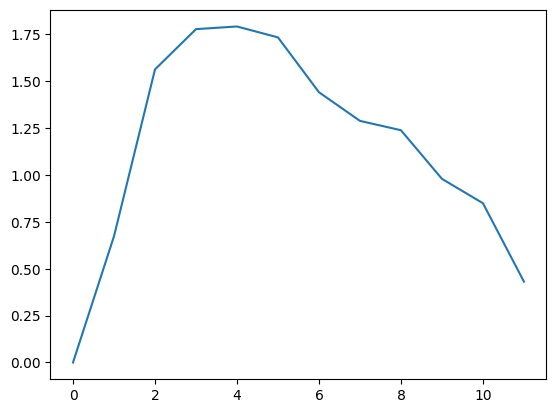

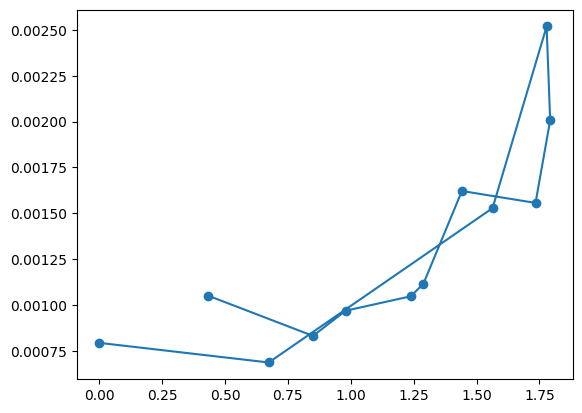

2016-01-01T12:45:30.000000000  to  2016-01-01T12:55:30.000000000
duration: 11
error: 0.11 0.122
walen slope: 0.055
<B>: 9.4
Altitude/azimuth: 81 / 283
Frame quality: 0.9940675697543984


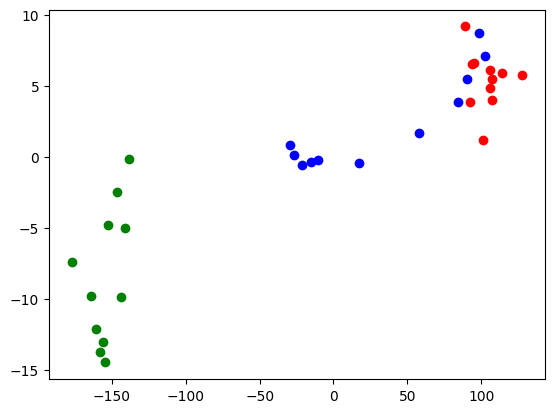

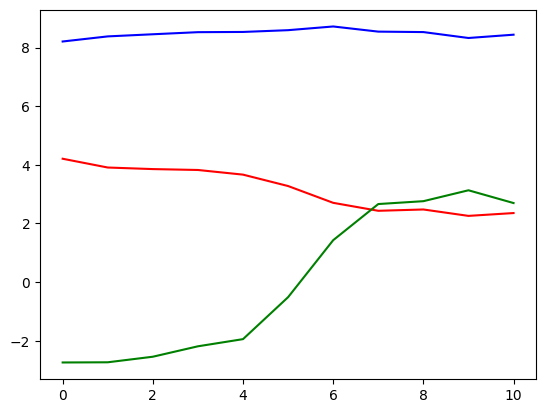

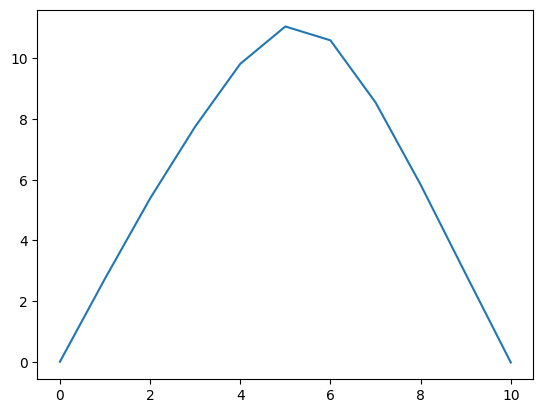

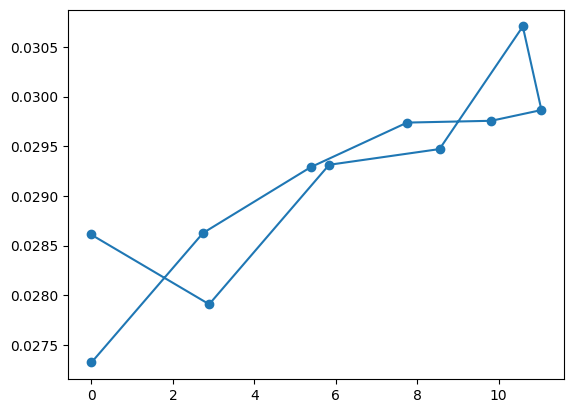

2016-01-01T13:33:30.000000000  to  2016-01-01T15:31:30.000000000
duration: 119
error: 0.113 0.122
walen slope: 0.015
<B>: 9.12
Altitude/azimuth: 101 / 244
Frame quality: 0.9957148048708849


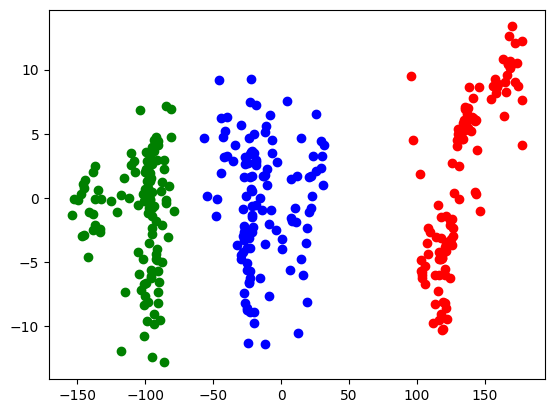

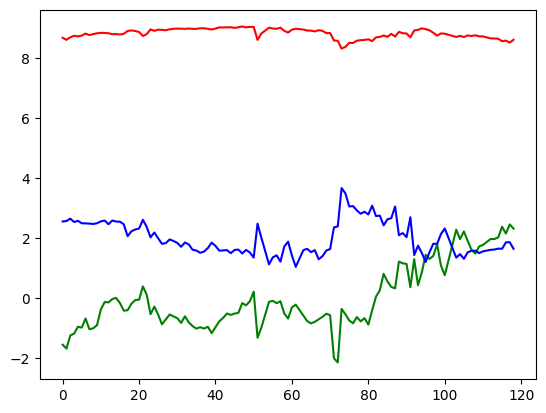

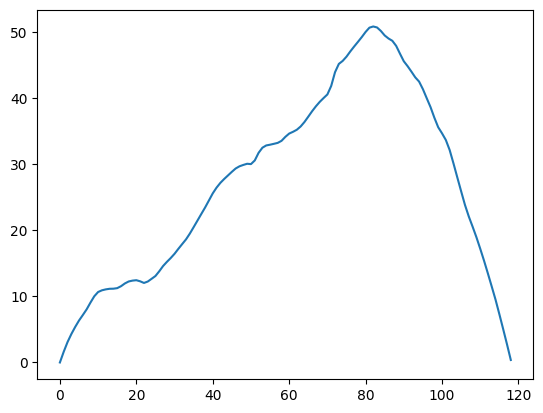

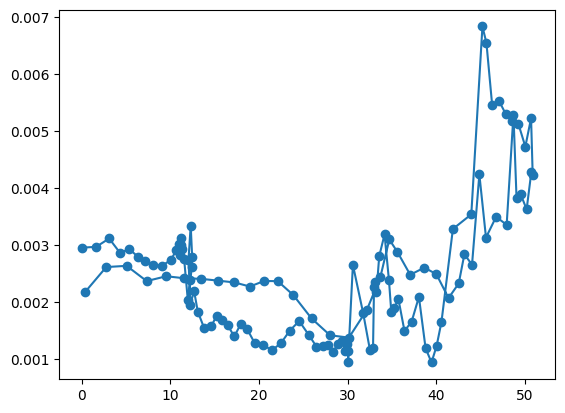

2016-01-01T15:35:30.000000000  to  2016-01-01T15:45:30.000000000
duration: 11
error: 0.119 0.124
walen slope: 0.284
<B>: 8.96
Altitude/azimuth: 81 / 330
Frame quality: 0.9936874383714204


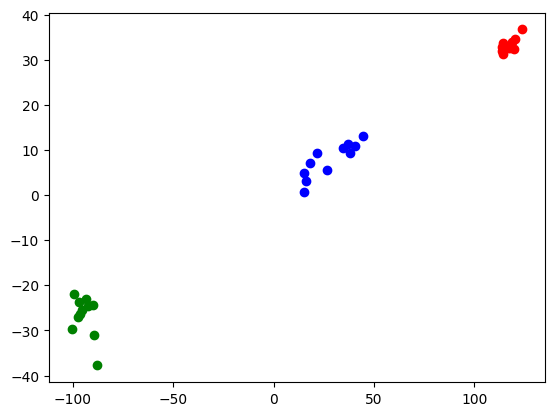

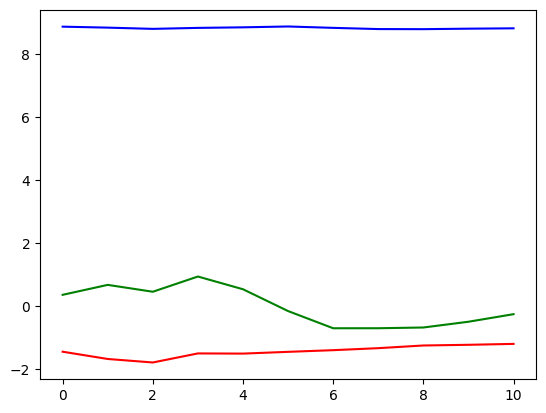

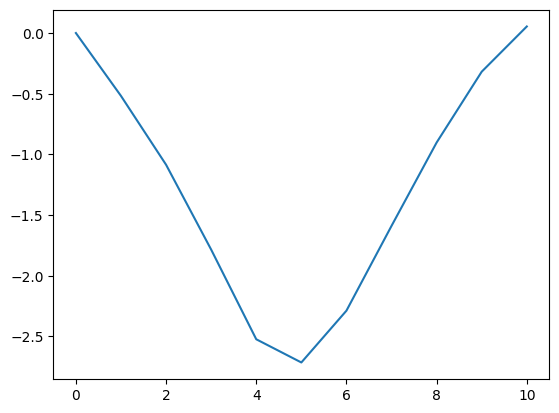

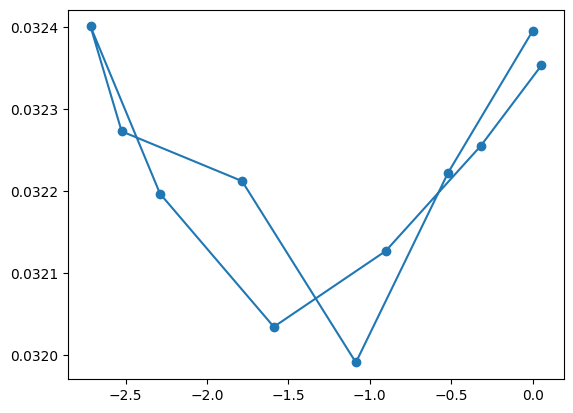

2016-01-01T16:07:30.000000000  to  2016-01-01T16:21:30.000000000
duration: 15
error: 0.075 0.101
walen slope: 0.249
<B>: 8.29
Altitude/azimuth: 90 / 306
Frame quality: 0.9931298239168675


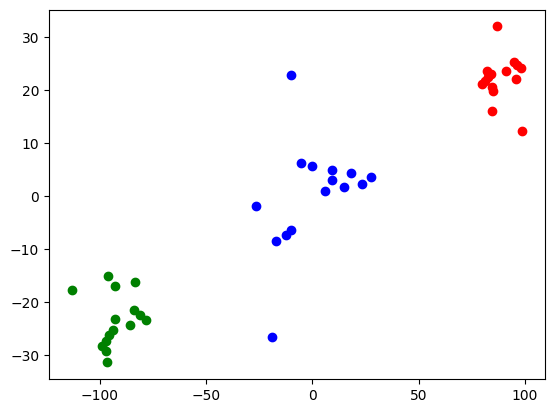

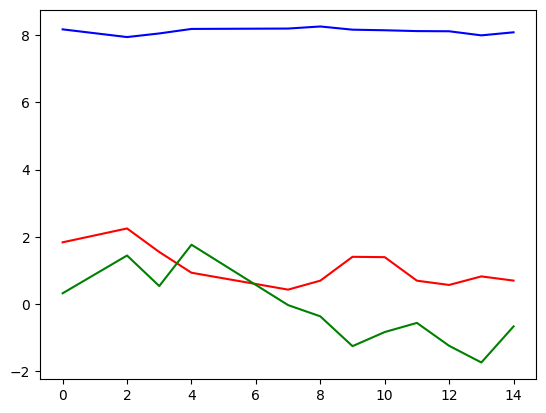

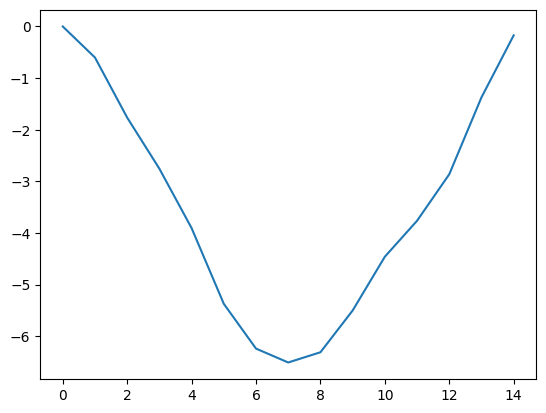

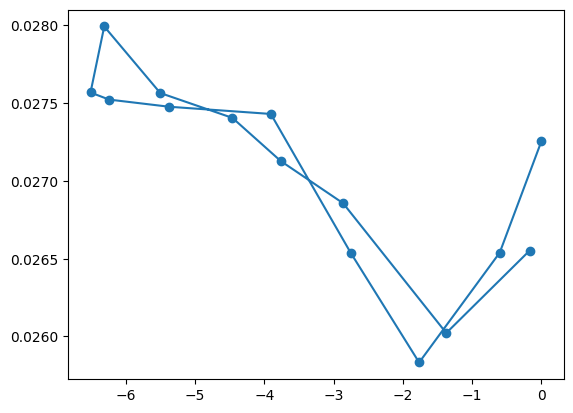

2016-01-01T18:21:30.000000000  to  2016-01-01T18:41:30.000000000
duration: 21
error: 0.118 0.128
walen slope: 0.155
<B>: 7.34
Altitude/azimuth: 87 / 306
Frame quality: 0.9952722201438395


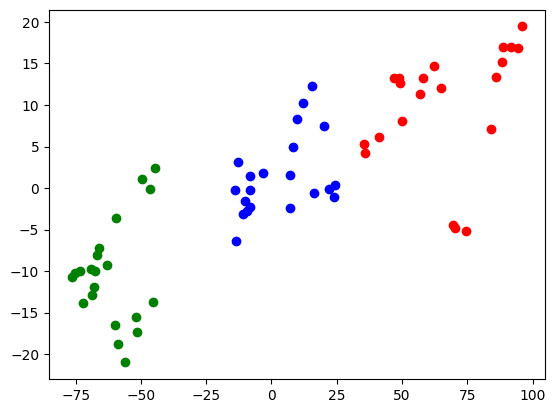

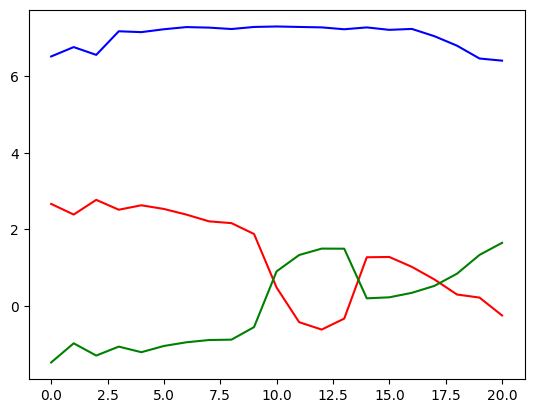

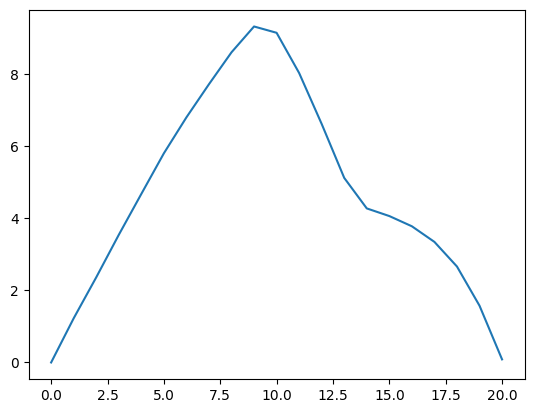

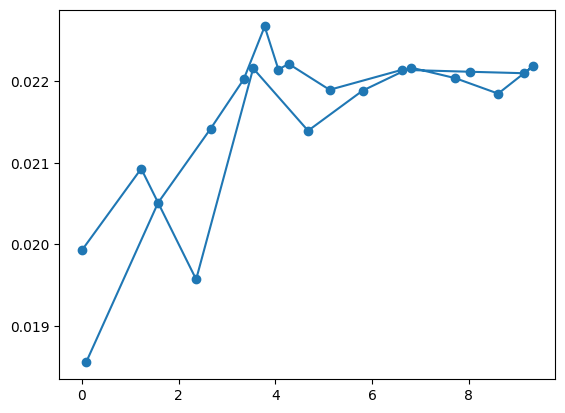

2016-01-01T19:21:30.000000000  to  2016-01-01T22:15:30.000000000
duration: 175
error: 0.116 0.117
walen slope: 0.298
<B>: 5.25
Altitude/azimuth: 70 / 248
Frame quality: 0.9937842571076698


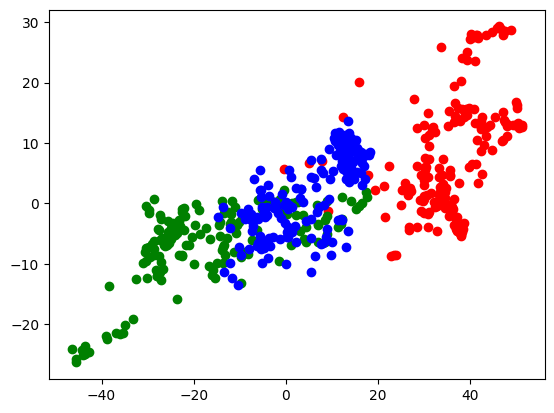

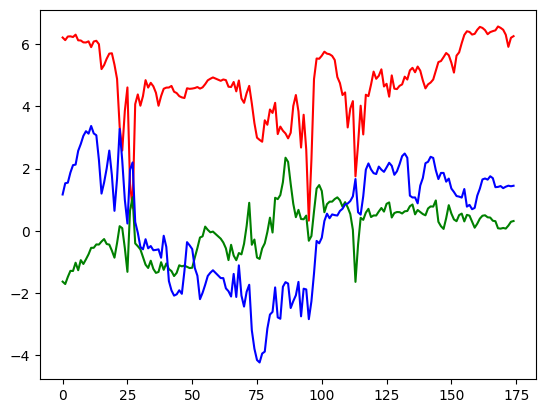

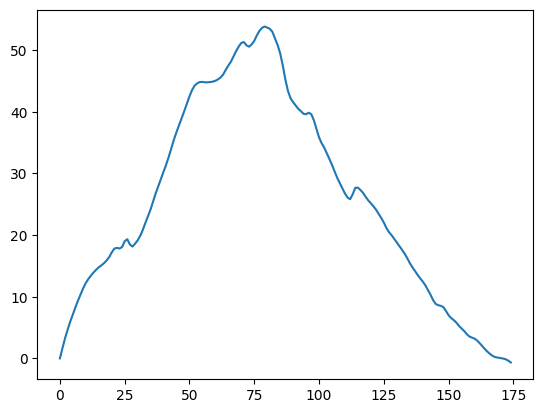

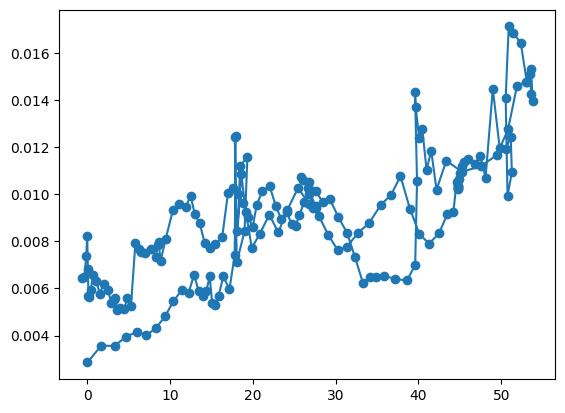

In [4]:
def spherical(x, y, z):
    altitude = np.rad2deg(np.arctan2(np.sqrt(x ** 2 + y ** 2), z))
    azimuth = np.rad2deg(np.arctan2(y, x))
    return altitude, azimuth


for i_result in results.index:
    axis = results[["axis_x", "axis_y", "axis_z"]].iloc[i_result]
    frame = results[["frame_x", "frame_y", "frame_z"]].iloc[i_result]
    start = results.start.iloc[i_result]
    duration = results.duration.iloc[i_result]
    end = results.end.iloc[i_result]
    residue = results.error_diff.iloc[i_result]
    error_fit = results.error_fit.iloc[i_result]

    z_unit = np.array(axis)
    frame = np.array(frame)

    event_velocity = velocity[start:start + duration].cpu().numpy()
    event_field = magnetic_field[start:start + duration].cpu().numpy()

    x_unit = -(frame - np.dot(frame, z_unit) * z_unit)
    x_unit = x_unit / np.linalg.norm(x_unit)
    y_unit = np.cross(z_unit, x_unit)
    rotation_matrix = np.column_stack([x_unit, y_unit, z_unit])
    rotation_matrix = rotation_matrix.T  # transpose gives inverse of rotation matrix

    event_density = density[start:start + duration].cpu().numpy()

    alfven_velocity = event_field / np.sqrt(scipy.constants.mu_0
                                            * scipy.constants.m_p
                                            * np.expand_dims(event_density, axis=1)) * 1e-15
    Pgas = gas_pressure[start:start + duration].cpu().numpy()
    remaining_flow = event_velocity - frame

    d_flow = remaining_flow - remaining_flow.mean()
    d_alfven = alfven_velocity - alfven_velocity.mean()
    walen_slope = (d_flow * d_alfven).sum() / (d_alfven ** 2).sum()

    # if walen_slope > 0.3:
    #     continue

    print(times[start], " to ", times[end])
    print("duration:", duration)
    print("error:", round(residue, 3), round(error_fit, 3))
    print("walen slope:", round(walen_slope, 3))
    print("<B>:", round(np.linalg.norm(event_field, axis=1).mean(), 2))
    altitude, azimuth = spherical(*axis)
    print("Altitude/azimuth:", round(altitude), "/", round(azimuth % 360))
    print("Frame quality:", scipy.stats.pearsonr(-np.cross(velocity, magnetic_field).flatten(),
                                                 -np.cross(frame, magnetic_field).flatten())[0])

    colors = ["red", "green", "blue"]

    for i_color, color in enumerate(colors):
        plt.scatter(alfven_velocity[:, i_color], remaining_flow[:, i_color], color=color)
    plt.show()

    rotated = rotation_matrix @ event_field.T
    for i_color, color in enumerate(colors):
        plt.plot(rotated[i_color], color=color)
    plt.show()

    dx = np.linalg.norm(np.dot(frame, x_unit))
    A = scipy.integrate.cumulative_trapezoid(-rotated[1], initial=0)
    plt.plot(A)
    plt.show()

    P = Pgas + (rotated[2] * 1e-9) ** 2 / (2 * 1.25663706212e-6) * 1e9
    plt.scatter(A, P)
    plt.plot(A, P)
    plt.show()